# Transformer Model
In this notebook, we show an example of how Transformer can be used with darts.
If you are new to darts, we recommend you first follow the `darts-intro.ipynb` notebook.

In [1]:
# fix python path if working locally
from utils import fix_pythonpath_if_working_locally
fix_pythonpath_if_working_locally()

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import shutil
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm_notebook as tqdm

from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.models import TransformerModel, ExponentialSmoothing
from darts.metrics import mape
from darts.utils.statistics import check_seasonality, plot_acf
from darts.datasets import AirPassengersDataset, SunspotsDataset

import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)

## Air Passengers Example

First, we will test the performance of the transformer architecture on the 'air passengers' dataset.

In [4]:
# Read data:
series = AirPassengersDataset().load()

# Create training and validation sets:
train, val = series.split_after(pd.Timestamp('19590101'))

# Normalize the time series (note: we avoid fitting the transformer on the validation set)
# Change name
scaler = Scaler()
train_scaled = scaler.fit_transform(train)
val_scaled = scaler.transform(val)
series_scaled = scaler.transform(series)

In [5]:
'the \'air passengers\' dataset has {} data points'.format(df.shape[0])

"the 'air passengers' dataset has 144 data points"

We train a standard transformer architecture with default hyperparameters, tweaking only two of them:

* _d\_model_, the input dimensionality of the transformer architecture (*after* performing time series embedding). Its default value is 512. We lower the value from 512 to 64, since it is hard to learn such an high-dimensional representation from an univariate time series
* _nhead_, the number of heads in the multi-head attention mechanism. We increase the value from 8 to 32. This means that we compute multi-head attention with 32 heads of size _d\_model_/_nhead_=64/32=2 each. This way, we obtain low-dimensional heads that are hopefully suitable to learn from univariate time series

The goal is to perform one-step forecasting.

In [8]:
my_model = TransformerModel(
    input_chunk_length = 12,
    output_chunk_length = 1,
    batch_size = 32,
    n_epochs = 400,
    model_name = 'air_transformer',
    log_tensorboard=True,
    nr_epochs_val_period = 10,
    d_model = 32,
    nhead = 16,
    num_encoder_layers = 3,
    num_decoder_layers = 3,
    dim_feedforward = 512,
    dropout = 0.1,
    activation = "relu",
    random_state=42,
    save_checkpotins=True
)

In [9]:
my_model.fit(series=train_scaled, val_series=val_scaled, verbose=True)

Training loss: 0.0027, validation loss: 0.0172, best val loss: 0.0067


Let's look at the predictions on the validation set.

First, by using the "current" model - i.e., the model at the end of the training procedure:

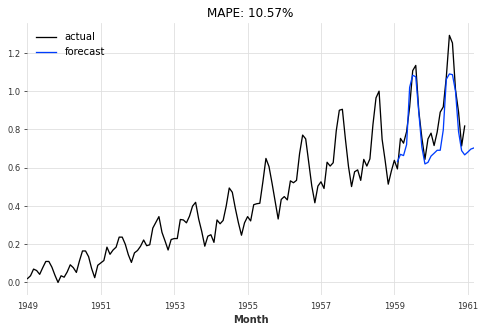

In [10]:
#this function evaluates a model on a given validation set for n time-steps
def eval_model(model, n, series, val_series):
    pred_series = model.predict(n=n)
    plt.figure(figsize=(8,5))
    series.plot(label='actual')
    pred_series.plot(label='forecast')
    plt.title('MAPE: {:.2f}%'.format(mape(pred_series, val_series)))
    plt.legend();
    
eval_model(my_model, 26, series_scaled, val_scaled)

Then, by using the best model obtained over training, according to validation loss:

loading model_best_220.pth.tar


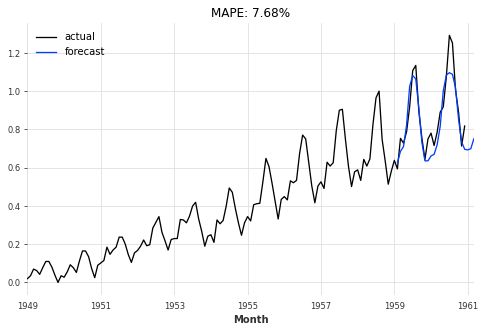

In [11]:
best_model = TransformerModel.load_from_checkpoint(model_name='air_transformer', best=True)
eval_model(best_model, 26, series_scaled, val_scaled)

Let's backtest our `Transformer` model to evaluates its performance at a forecast horizon of 6 months:

In [12]:
backtest_series = my_model.historical_forecasts(series = series_scaled,
                                                start = pd.Timestamp('19590101'), 
                                                forecast_horizon = 6,
                                                retrain = False,
                                                verbose = True)

MAPE: 6.19%


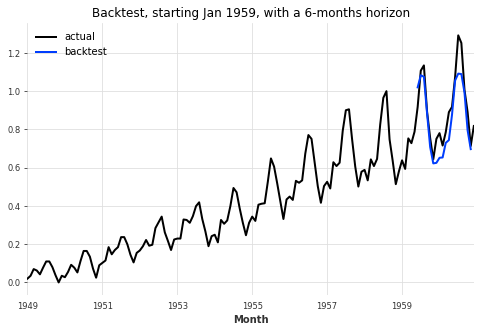

In [13]:
plt.figure(figsize=(8,5))
series_scaled.plot(label='actual', lw=2)
backtest_series.plot(label='backtest', lw=2)
plt.legend()
plt.title('Backtest, starting Jan 1959, with a 6-months horizon');
print('MAPE: {:.2f}%'.format(mape(scaler.inverse_transform(series_scaled), 
                                  scaler.inverse_transform(backtest_series))))

### Monthly Sun spots Example

Now, let's test the transformer architecture on a more complex dataset, the 'monthly sunspots'. 

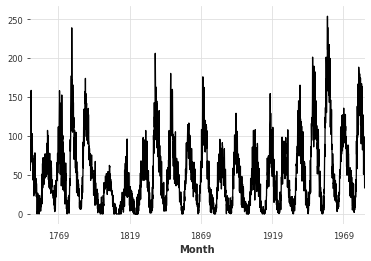

In [14]:
series_sunspot = SunspotsDataset().load()

series_sunspot.plot()
check_seasonality(series_sunspot, max_lag=240)

train_sp, val_sp = series_sunspot.split_after(pd.Timestamp('19401001'))

scaler_sunspot = Scaler()
train_sp_scaled = scaler_sunspot.fit_transform(train_sp)
val_sp_scaled = scaler_sunspot.transform(val_sp)
series_sp_scaled = scaler_sunspot.transform(series_sunspot)

In [15]:
'the \'monthly sun spots\' dataset has {} data points'.format(df2.shape[0])

"the 'monthly sun spots' dataset has 2820 data points"

First, let's perform one-step ahead forecasting.

In [16]:
my_model_sp = TransformerModel(
    batch_size = 32,
    input_chunk_length = 125,
    output_chunk_length = 36,
    n_epochs = 20,
    model_name = 'sun_spots_transformer',
    log_tensorboard=True,
    nr_epochs_val_period = 5,
    d_model = 32,
    nhead = 8,
    num_encoder_layers = 4,
    num_decoder_layers = 4,
    dim_feedforward = 512,
    dropout = 0.1,
    random_state=42,
    optimizer_kwargs={'lr': 1e-3},
    save_checkpoints=True
)

In [17]:
my_model_sp.fit(series=train_sp_scaled, val_series=val_sp_scaled, verbose=True)

Training loss: 0.0105, validation loss: 0.0253, best val loss: 0.0232


loading model_best_10.pth.tar



Transformer MAPE: 67.35159696769936
ETS MAPE: 593.7817328101518


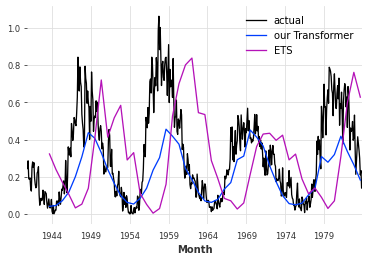

In [18]:
# this function is used to backtest the model at a forecasting horizon of three years (36 months)
def backtest(testing_model):
    # Compute the backtest predictions with the two models
    pred_series = testing_model.historical_forecasts(series = series_sp_scaled, 
                                                     start = pd.Timestamp('19401001'), 
                                                     forecast_horizon = 36,
                                                     stride = 10,
                                                     retrain = False,
                                                     verbose = True)
    
    pred_series_ets = ExponentialSmoothing().historical_forecasts(series = series_sp_scaled,
                                                                  start = pd.Timestamp('19401001'), 
                                                                  forecast_horizon = 36,
                                                                  stride = 10,
                                                                  retrain = True,
                                                                  verbose = True)
    val_sp_scaled.plot(label = 'actual')
    pred_series.plot(label = 'our Transformer')
    pred_series_ets.plot(label = 'ETS')
    plt.legend();
    print("Transformer MAPE:", mape(pred_series, val_sp_scaled))
    print("ETS MAPE:", mape(pred_series_ets, val_sp_scaled))
    
best_model_sp = TransformerModel.load_from_checkpoint(model_name='sun_spots_transformer', best=True)
backtest(best_model_sp)